# Define projection transformation 

Transforming between standard web lat & long, and VicGrid eastings and northings on GDA2020

In [1]:
!pip install pyproj

from pyproj import CRS
from pyproj import Transformer

CRS_WEB = CRS.from_epsg(4326)
CRS_VIC = CRS.from_epsg(7899)
WEB2VIC = Transformer.from_crs(CRS_WEB, CRS_VIC)
VIC2WEB = Transformer.from_crs(CRS_VIC, CRS_WEB)

def web2vic(lat, lng):
    return WEB2VIC.transform(lat, lng)

def vic2web(east, north):
    return VIC2WEB.transform(east, north)

# Define a reference point

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

Melbourne in round figures gives a reference rate of change of latitude with respect to northings, and longitude with respect to eastings

In [3]:
EARTH_RADIUS = 6371000
REF_LAT = -38
REF_LNG = 145

m_per_lat = EARTH_RADIUS * math.pi / 180
m_per_lng = m_per_lat * math.cos(REF_LAT * math.pi / 180)
dldn_ref = 1 / m_per_lat
dlde_ref = 1 / m_per_lng

dldn_ref, dlde_ref

(8.993216059187306e-06, 1.1412554991191925e-05)

# Define a grid over Victoria

In [4]:
vg_bl = (2081523, 2262223)
vg_tr = (2953132, 2942855)
grid_step = 6000
eastings = np.arange(vg_bl[0], vg_tr[0], grid_step)
northings = np.arange(vg_bl[1], vg_tr[1], grid_step)

In [5]:
ref_e, ref_n = web2vic(REF_LAT, REF_LNG)
ref_ei = np.argmin(np.abs(eastings - ref_e))
ref_ni = np.argmin(np.abs(northings - ref_n))

# Transform every grid point to lat, long

In [6]:
ee, nn = np.meshgrid(eastings, northings)
lats, lngs = vic2web(ee, nn)

And calculate differences

In [7]:
dlat0 = np.diff(lats, axis=0)
dlat1 = np.diff(lats, axis=1)
dlng0 = np.diff(lngs, axis=0)
dlng1 = np.diff(lngs, axis=1)

In [8]:
dlat0_c = dlat0[:, :dlat1.shape[1]]
dlat1_c = dlat1[:dlat0.shape[0], :]
dlng0_c = dlng0[:, :dlng1.shape[1]]
dlng1_c = dlng1[:dlng0.shape[0], :]

# Plot the deviation between coordinates

In [9]:
dlat_dnn = dlat0_c / 6000
dldn_pd = (dlat_dnn / dldn_ref - 1) * 100

dlng_dee = dlng1_c / 6000
dlde_pd = (dlng_dee / dlde_ref - 1) * 100

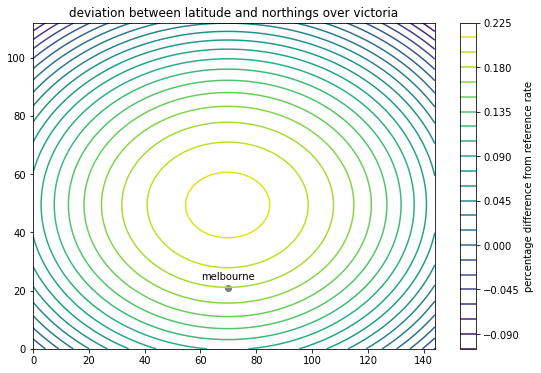

In [10]:
plt.figure(figsize=(9, 6))
plt.contour(dldn_pd, 20)
plt.colorbar(label='percentage difference from reference rate')
plt.scatter(ref_ei, ref_ni, color='grey')
plt.text(ref_ei, ref_ni + 2, 'melbourne', ha='center', va='bottom')
plt.title('deviation between latitude and northings over victoria')
plt.show()

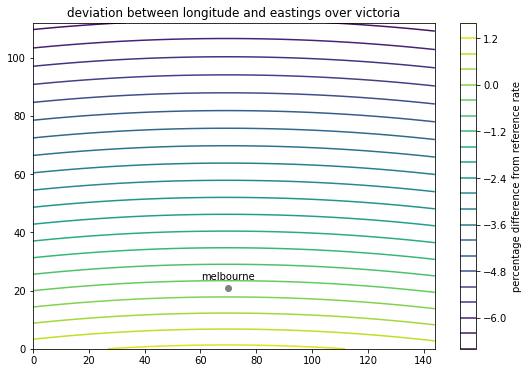

In [11]:
plt.figure(figsize=(9, 6))
plt.contour(dlde_pd, 20)
plt.colorbar(label='percentage difference from reference rate')
plt.scatter(ref_ei, ref_ni, color='grey')
plt.text(ref_ei, ref_ni + 2, 'melbourne', ha='center', va='bottom')
plt.title('deviation between longitude and eastings over victoria')
plt.show()

# Can we get both on one chart?

Quiver plot can do this but arrow direction representing deviation in rate change isn't super intuitive

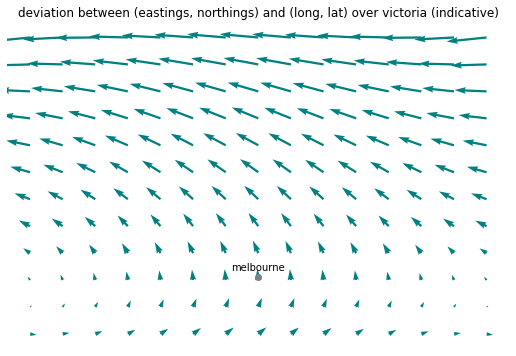

In [12]:
smp = 10
qus = dlde_pd[::smp,::smp]
qvs = dldn_pd[::smp,::smp] * 10

plt.figure(figsize=(9, 6))
plt.quiver(qus, qvs, color='teal')
plt.scatter(ref_ei / smp, ref_ni / smp, color='grey')
plt.text(ref_ei / smp, ref_ni / smp + 0.2, 'melbourne', ha='center', va='bottom')
plt.axis('off')
plt.title('deviation between (eastings, northings) and (long, lat) over victoria (indicative)')
plt.show()

# Is this more intutive?

I thought multiple arrows indicating whether the rate in both dimensions was "squased" or "stretched" might be more intuitive

In [13]:
def quiver_decorated(U, V, pivot, color, scale=200, width=0.005):
  plt.quiver(U, V, pivot=pivot, color=color, scale=scale, width=width, headlength=2, headaxislength=2)

def squash_stretch(U, V, scale_factor=1):
  zeros = np.zeros(U.shape)
  max_max = max(np.max(np.abs(U)), np.max(np.abs(V)))
  # horz
  gth = np.where(U > 0, U, zeros)
  lth = np.where(U < 0, U, zeros)
  # vert
  gtv = np.where(V > 0, V, zeros)
  ltv = np.where(V < 0, V, zeros)
  #
  scale = max_max * scale_factor
  c_in = 'teal'
  c_out = 'deeppink'
  # plot
  quiver_decorated(gth, zeros, pivot='tail', color=c_out, scale=scale)
  quiver_decorated(-gth, zeros, pivot='tail', color=c_out, scale=scale)
  quiver_decorated(lth, zeros, pivot='tip', color=c_in, scale=scale)
  quiver_decorated(-lth, zeros, pivot='tip', color=c_in, scale=scale)
  quiver_decorated(zeros, gtv, pivot='tail', color=c_out, scale=scale)
  quiver_decorated(zeros, -gtv, pivot='tail', color=c_out, scale=scale)
  quiver_decorated(zeros, ltv, pivot='tip', color=c_in, scale=scale)
  quiver_decorated(zeros, -ltv, pivot='tip', color=c_in, scale=scale)

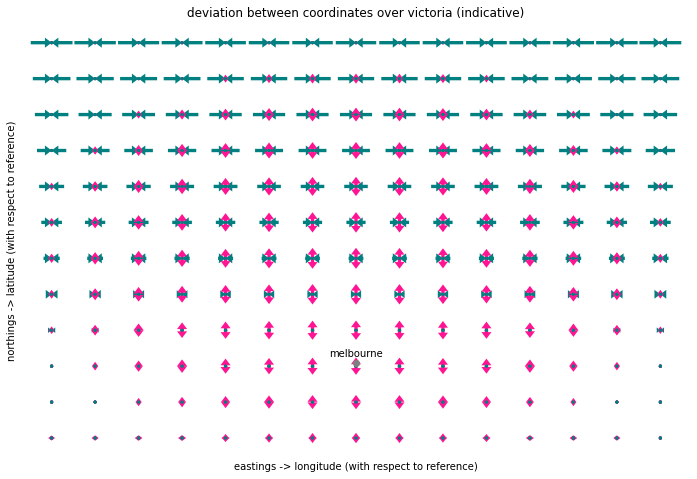

In [14]:
smp = 10
qus = dlde_pd[::smp,::smp]
qvs = dldn_pd[::smp,::smp] * 15

plt.figure(figsize=(12, 8))
squash_stretch(qus, qvs, 32)
plt.scatter(ref_ei / smp, ref_ni / smp, color='grey')
plt.text(ref_ei / smp, ref_ni / smp + 0.1, 'melbourne', ha='center', va='bottom')
plt.title('deviation between coordinates over victoria (indicative)')
plt.xlabel('eastings -> longitude (with respect to reference)')
plt.ylabel('northings -> latitude (with respect to reference)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.show()

I might extend this to a proper "strain" representation considering shear and principal directions in future...